# Import Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time
import h5py
from scipy.stats import norm
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
import torch.nn.functional as F
# import pandas as pd
import datetime
import os
# import readligo as rl
# from gwpy.timeseries import TimeSeries
import math
import random

import copy

In [2]:
epochs = 50
rTrain = 0.7;
rTest = 0.2;
rValidation = 0.1
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Test training

## AE structure

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

## Data preparation

In [13]:
renorm_factor = 20;

realbkg = np.load("../data/Datasets/background.npz")['data'][:, 0] / renorm_factor;
realbbh = np.load("../data/Datasets/bbh_for_challenge.npy")[:, 0]  / renorm_factor;
realsg = np.load("../data/Datasets/sglf_for_challenge.npy")[:, 0] / renorm_factor;
# realglitch = np.load("../data/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"]

bkg_fft = abs(np.fft.rfft(realbkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T
bbh_fft = abs(np.fft.rfft(realbbh))
bbh_fft = bkg_fft/np.linalg.norm([bbh_fft], axis=2).T
sg_fft = abs(np.fft.rfft(realsg))
sg_fft = bkg_fft/np.linalg.norm([sg_fft], axis=2).T

/home/sida/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/sida/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
/tmp/ipykernel_25164/822222561.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(

Epoch: 0001, Training loss=0.009637, Validation loss=0.009518
Time for this epoch: 2.6162633895874023
Epoch: 0002, Training loss=0.002640, Validation loss=0.002701
Time for this epoch: 2.6476988792419434
Epoch: 0003, Training loss=0.002330, Validation loss=0.002234
Time for this epoch: 2.666247606277466
Epoch: 0004, Training loss=0.002131, Validation loss=0.002142
Time for this epoch: 2.670827865600586
Epoch: 0005, Training loss=0.002090, Validation loss=0.002116
Time for this epoch: 2.6767075061798096
Epoch: 0006, Training loss=0.002150, Validation loss=0.002097
Time for this epoch: 2.6738619804382324
Epoch: 0007, Training loss=0.002154, Validation loss=0.002074
Time for this epoch: 2.675849199295044
Epoch: 0008, Training loss=0.001986, Validation loss=0.002052
Time for this epoch: 2.6685914993286133
Epoch: 0009, Training loss=0.002071, Validation loss=0.002029
Time for this epoch: 2.6729490756988525
Epoch: 0010, Training loss=0.001934, Validation loss=0.002006
Time for this epoch: 2.

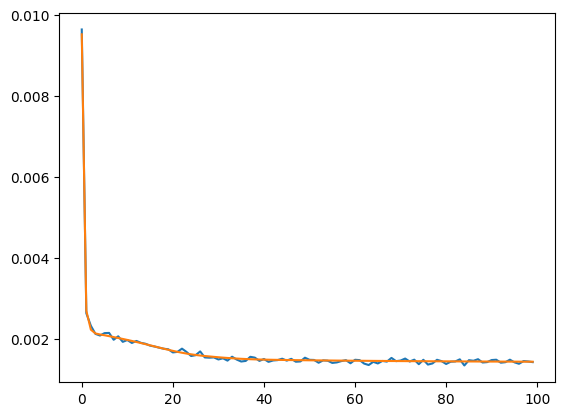

In [16]:
dataset = bkg_fft
nTotal = len(dataset);
nTrain = int(rTrain * nTotal)
nTest = int(rTest * nTotal)

X_train = dataset[:nTrain]
X_test = dataset[-nTest:]
X_validation = dataset[nTrain:-nTest]

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True, drop_last=True)

autoencoder = AutoEncoder().cpu()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
loss_func = nn.MSELoss().cpu()
loss_train = np.zeros(epochs)
loss_validation = np.zeros(epochs)

wNorm = 0;

for epoch in range(epochs):
    t0 = time.time()

    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cpu()
        encoded, decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        weighted_lossTrain = loss_overall

        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term

        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cpu()
            encoded, decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal = lossVal_overall
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = weighted_lossTrain.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f' % (epoch+1, loss_train[epoch], val_loss))
    print('Time for this epoch: ' + str(time.time() - t0))

plt.plot(loss_train)
plt.plot(loss_validation)

# Fine, test the new CNNAE for comparison

## AE

In [4]:
epochs = 50
rTrain = 0.7;
rTest = 0.2;
rValidation = 0.1
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

In [5]:
class WaveletCNNAE_xc(nn.Module):
    
    def __init__(
        self, 
        num_ifos: int,
        c_depth: int=8, 
        n_chann: int=64, 
        l1: int=1024
        # lx: int=200
    ):
        
        super(WaveletCNNAE_xc, self).__init__()
        
        self.c_depth = c_depth
        self.n_chann = n_chann
        
        self.cap_norm = nn.GroupNorm(num_ifos, num_ifos)
        
        self.Conv_In_encode = nn.Conv1d(
                in_channels=num_ifos, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_encode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=1, 
                kernel_size=1
            )
        
        self.Conv_In_decode = nn.Conv1d(
                in_channels=1, 
                out_channels=self.n_chann, 
                kernel_size=1
            )
        
        self.Conv_Out_decode = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=num_ifos, 
                kernel_size=1
            )
        
        self.body_norm_encode = nn.GroupNorm(4 ,n_chann)
        self.body_norm_decode = nn.GroupNorm(4 ,n_chann)
        self.end_norm_encode = nn.BatchNorm1d(1)
        self.end_norm_decode = nn.BatchNorm1d(1)
        
        self.WaveNet_layers_encode = nn.ModuleList()
        self.WaveNet_layers_decode = nn.ModuleList()
        self.WaveNet_layers_dp = nn.ModuleList()
        
        
        for i in range(self.c_depth):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_encode.append(conv_layer)
            
        for i in range(self.c_depth-1, -1, -1):

            conv_layer = nn.Conv1d(
                in_channels=self.n_chann, 
                out_channels=self.n_chann,
                kernel_size=2,
                dilation=2**i
            )
            
            self.WaveNet_layers_decode.append(conv_layer)
            self.WaveNet_layers_dp.append(nn.ZeroPad1d(2**i))
        
        
#         self.Padding_layer = nn.ZeroPad1d(2**c_depth - 1)
                
        # self.L1 = nn.Linear(8192-2**c_depth, l1)
        
        # Consider replacing other batch normalizatoin layers with other nor method
        # Because batch norm are baised by the population of the CCSN rate in one batch 
        # This may produce overfitting model and will not be able to found at test phase
        # Question: Will we be able to figure out the side effect at infereceing phase?
                
#         self.conv_norm = nn.BatchNorm1d(200-2**c_depth + 1)
        self.L1 = nn.Linear(200-2**c_depth + 1, l1)
        self.L1_norm = nn.BatchNorm1d(l1)
        self.L2 = nn.Linear(l1, 200-2**c_depth + 1)
        self.L2_norm = nn.BatchNorm1d(200-2**c_depth + 1)

        nn.init.kaiming_normal_(self.Conv_In_encode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_encode.weight)
        nn.init.constant_(self.Conv_In_encode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_encode.bias, 0.001)
        
        nn.init.kaiming_normal_(self.Conv_In_decode.weight)
        nn.init.kaiming_normal_(self.Conv_Out_decode.weight)
        nn.init.constant_(self.Conv_In_decode.bias, 0.001)
        nn.init.constant_(self.Conv_Out_decode.bias, 0.001)

        # Initialize all the convolutional layer in between
        for conv_layer in self.WaveNet_layers_encode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)
            
        for conv_layer in self.WaveNet_layers_decode:
            nn.init.kaiming_normal_(conv_layer.weight)
            nn.init.constant_(conv_layer.bias, 0.001)    

        nn.init.kaiming_uniform_(self.L1.weight)
        nn.init.kaiming_uniform_(self.L2.weight)
        nn.init.constant_(self.L1.bias, 0.001)
        nn.init.constant_(self.L2.bias, 0.001)
        
    def encode(self, x):
        
        x = self.cap_norm(x)
        x = self.Conv_In_encode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for what_are_u_wavin_at in self.WaveNet_layers_encode:
            x = self.body_norm_encode(x)
            x = what_are_u_wavin_at(x)
            x = F.relu(x)
            
        x = self.Conv_Out_encode(x)
        x = F.relu(x)
        x = self.end_norm_encode(x)
        
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.L1_norm(F.relu(self.L1(x)))
        
        # print('Encoder done')
        
        return x
    
    def decode(self, x):
        x = self.L2_norm(F.relu(self.L2(x)))
        
#         x = self.Padding_layer(x)
        
        x = torch.unsqueeze(x,1)

        # print(x.shape)
        
        # x = self.cap_norm(x)
        x = self.Conv_In_decode(x)
        x = F.relu(x)
        
        # x = self.norm(x)
        
        for (pad, dcd) in zip(self.WaveNet_layers_dp, self.WaveNet_layers_decode):
            # print(x.shape)
            x = self.body_norm_decode(x)
            x = pad(x)
            x = torch.flip(dcd(torch.flip(x, [-1])), [-1])
            x = F.relu(x)
        
        # print(x.shape)
        # print('CNN done')
        
        x = self.Conv_Out_decode(x)
        # print(x.shape)
        x = F.tanh(x)
        # print(x.shape)
        # x = self.end_norm_decode(x)
        
        # x = torch.flatten(x, 1)
        
        
        return x
    
    def forward(self,x):
        return self.decode(self.encode(x))

## data loading

In [6]:
realbkg = np.load('../data/Datasets/real_bkg_2202000_63917s_4000Hz_50ms.npy')[:100000]
# perm = np.random.permutation(len(realbkg))
perm = np.loadtxt("../results/CNN_glitch/perm_noise.dat").astype(int)
print(realbkg.shape)
realbkg = realbkg / np.linalg.norm([realbkg], axis=2).T
realbkg = realbkg[perm]
realbkg = realbkg.reshape(-1,1,200);
print(realbkg.shape)
# np.savetxt("../results/CNN_glitch/perm_noise.dat", perm);

realglitch = np.load("../data/Datasets/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"]
# perm = np.random.permutation(len(realglitch))
perm = np.loadtxt("../results/CNN_glitch/perm_glitch.dat").astype(int)
print(realglitch.shape)
realglitch = realglitch / np.linalg.norm([realglitch], axis=2).T
realglitch = realglitch[perm]
realglitch = realglitch.reshape(-1,1,200);
print(realglitch.shape)
# np.savetxt("../results/CNN_glitch/perm_glitch.dat", perm);

(100000, 200)
(100000, 1, 200)
(60132, 200)
(60132, 1, 200)


In [7]:
realbkg_reserved = realbkg[-int(0.2 * len(realbkg))-int(0.2 * len(realbkg))%2:]
realglitch_reserved = realglitch[-int(0.2 * len(realglitch))-int(0.2 * len(realglitch))%2:]

realbkg = realbkg[:-int(0.2 * len(realbkg))-int(0.2 * len(realbkg))%2]
realglitch = realglitch[:-int(0.2 * len(realglitch))-int(0.2 * len(realglitch))%2]

## training

In [8]:
n_BKG = len(realbkg)
n_GLITCH = len(realglitch)

rTrain = 1-rValidation

n_BKG_train = int(n_BKG * rTrain)
n_GLITCH_train = int(n_GLITCH * rTrain)

n_BKG_validation = int(n_BKG * rValidation)
n_GLITCH_validation = int(n_GLITCH * rValidation)

In [9]:
X_train = realglitch[:n_GLITCH_train]
X_validation = realglitch[-n_GLITCH_validation:]

train_dataset = TensorDataset(torch.FloatTensor(X_train))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [12]:
list_roc = {};

for cd in [3, 4, 5, 6]:
    for nch in [4, 8, 12]:
        for nl1 in [10, 20, 30]:
            
            modelName = "dep_"+str(cd)+"_chnl_"+str(nch)+"_btn_"+str(nl1);
            key = "c_depth-"+str(cd)+"-n_chann-"+str(nch)+"-bottleneck-"+str(nl1);
            ae = torch.load("../results/CNN_glitch/model_"+modelName+".pt").cpu().eval();
            err_bkg = np.sort(np.var(ae(torch.FloatTensor(realbkg_reserved)).detach().numpy() - realbkg_reserved, axis=-1).flatten())
            err_glitch = np.sort(np.var(ae(torch.FloatTensor(realglitch_reserved)).detach().numpy() - realglitch_reserved, axis=-1).flatten())

            fpr = np.empty((99, ))
            tpr = np.empty((99, ))
            
            for i in range(1, 100):
                FP = int(0.01*i*len(err_glitch));
                th = err_glitch[-FP];
                TP = np.sum(err_bkg > th)

                fpr[i-1] = FP/len(err_glitch)
                tpr[i-1] = TP/len(err_bkg)

            list_roc[key] = np.array([fpr, tpr])

torch.save(list_roc, "../results/CNN_glitch/roc_collection.json")

AttributeError: expected 'f' to be string, path, or a file-like object with a 'write' attribute

In [14]:
torch.save(list_roc, "../results/CNN_glitch/roc_collection.json")

In [12]:
cnt = 0
for cd in [3, 4, 5, 6]:
    for nch in [4, 8, 12]:
        for nl1 in [10, 20, 30]:
            cnt += 1
            if cnt < 17:
                continue
            
            modelName = "dep_"+str(cd)+"_chnl_"+str(nch)+"_btn_"+str(nl1);
            ae = WaveletCNNAE_xc(num_ifos=1, c_depth=cd, n_chann=nch, l1=nl1).cpu()
            
            optimizer = optim.Adam(ae.parameters(), lr=0.00005)
            loss_func = nn.MSELoss().cpu()
            loss_train = np.empty((epochs, ))
            loss_validation = np.empty((epochs, ))
            
            for epoch in range(epochs):
            
                t0 = time.time()
                ae.train()
                for batchidx, x in enumerate(trainDataLoader):
                    x = x[0].cpu()
                    # print(x.shape)
                    # tgt_index = tgt_index.cpu()
                    output = ae(x)
                    loss = loss_func(output, x)
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
                ae.eval()
                with torch.no_grad():
                    val_loss = 0
                    n_correct = 0;
                    for batchidx, x in enumerate(validationDataLoader):
                        x = x[0].cpu()
                        # tgt_index = tgt_index.cpu()
                        output = ae(x)
                        lossVal = loss_func(output, x)
                        val_loss += lossVal.item()
                        # n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()
            
                    val_loss /= len(validationDataLoader)
            
                loss_train[epoch] = loss.item()
                loss_validation[epoch] = val_loss
                # print('Epoch: %04d, Training loss=%f, Validation loss=%f' % (epoch+1, loss_train[epoch], val_loss))
                # print('Time for this epoch: ' + str(time.time() - t0))
            
            #     print(time.time() - t0)
            
            plt.plot(loss_train)
            plt.plot(loss_validation)
            plt.savefig("../results/CNN_glitch/loss_"+modelName+".jpg");
            plt.close();
            ae.eval();
            torch.save(ae, "../results/CNN_glitch/model_"+modelName+".pt");

            foo = plt.hist(np.var(ae(torch.FloatTensor(realbkg_reserved)).detach().numpy() - realbkg_reserved, axis=-1).flatten(), bins=50, range=(0, 0.005), density=True, histtype="step", label="noise")
            foo = plt.hist(np.var(ae(torch.FloatTensor(realglitch_reserved)).detach().numpy() - realglitch_reserved, axis=-1).flatten(), bins=50, range=(0, 0.005), density=True, histtype="step", label="glitch")
            plt.legend()
            plt.savefig("../results/CNN_glitch/err_"+modelName+".jpg");
            plt.close();
            print([cd, nch, nl1]);

/home/sida/miniconda3/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[4, 12, 20]
[4, 12, 30]
[5, 4, 10]
[5, 4, 20]
[5, 4, 30]
[5, 8, 10]
[5, 8, 20]
[5, 8, 30]
[5, 12, 10]
[5, 12, 20]
[5, 12, 30]
[6, 4, 10]
[6, 4, 20]
[6, 4, 30]
[6, 8, 10]
[6, 8, 20]
[6, 8, 30]
[6, 12, 10]
[6, 12, 20]
[6, 12, 30]


8775
Epoch: 0001, Training loss=0.242619, Validation loss=0.239548
Time for this epoch: 24.70982789993286
Epoch: 0002, Training loss=0.111781, Validation loss=0.105309
Time for this epoch: 24.60343599319458
Epoch: 0003, Training loss=0.054903, Validation loss=0.052195
Time for this epoch: 23.996695280075073
Epoch: 0004, Training loss=0.033135, Validation loss=0.031306
Time for this epoch: 23.50935959815979
Epoch: 0005, Training loss=0.021132, Validation loss=0.020844
Time for this epoch: 23.796576261520386
Epoch: 0006, Training loss=0.014935, Validation loss=0.015122
Time for this epoch: 24.009051084518433
Epoch: 0007, Training loss=0.011831, Validation loss=0.011102
Time for this epoch: 24.42750072479248
Epoch: 0008, Training loss=0.007567, Validation loss=0.007639
Time for this epoch: 24.59000515937805
Epoch: 0009, Training loss=0.006025, Validation loss=0.006031
Time for this epoch: 24.588029623031616
Epoch: 0010, Training loss=0.005623, Validation loss=0.005547
Time for this epoch:

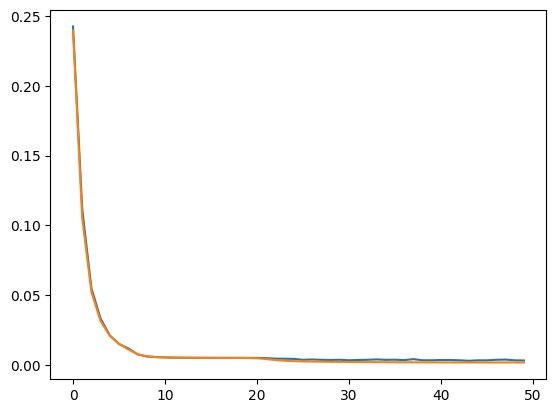

In [73]:
ae = WaveletCNNAE_xc(num_ifos=1, c_depth=5, n_chann=8, l1=20).cpu()
print(sum(p.numel() for p in ae.parameters() if p.requires_grad))

optimizer = optim.Adam(ae.parameters(), lr=0.00002)
loss_func = nn.MSELoss().cpu()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    ae.train()
    for batchidx, x in enumerate(trainDataLoader):
        x = x[0].cpu()
        # print(x.shape)
        # tgt_index = tgt_index.cpu()
        output = ae(x)
        loss = loss_func(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ae.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, x in enumerate(validationDataLoader):
            x = x[0].cpu()
            # tgt_index = tgt_index.cpu()
            output = ae(x)
            lossVal = loss_func(output, x)
            val_loss += lossVal.item()
            # n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f' % (epoch+1, loss_train[epoch], val_loss))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

In [62]:
ae.eval()

WaveletCNNAE_xc(
  (cap_norm): GroupNorm(1, 1, eps=1e-05, affine=True)
  (Conv_In_encode): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
  (Conv_Out_encode): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
  (Conv_In_decode): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
  (Conv_Out_decode): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
  (body_norm_encode): GroupNorm(4, 8, eps=1e-05, affine=True)
  (body_norm_decode): GroupNorm(4, 8, eps=1e-05, affine=True)
  (end_norm_encode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (end_norm_decode): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (WaveNet_layers_encode): ModuleList(
    (0): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
    (1): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): Conv1d(8, 8, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): Conv1d(8, 8, kernel_size=(2,), stride=(1,)

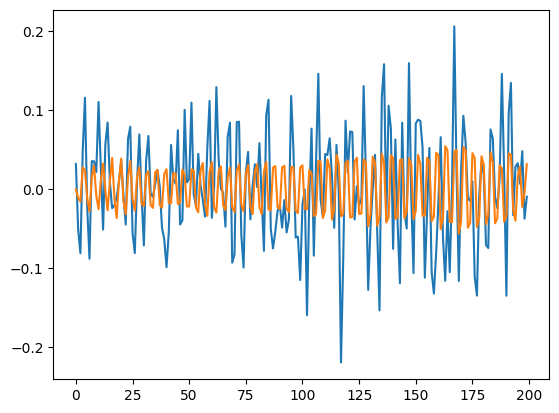

In [74]:
plt.plot(realglitch[0, 0])
plt.plot(ae(torch.FloatTensor(realglitch[0:1])).detach().numpy().flatten())

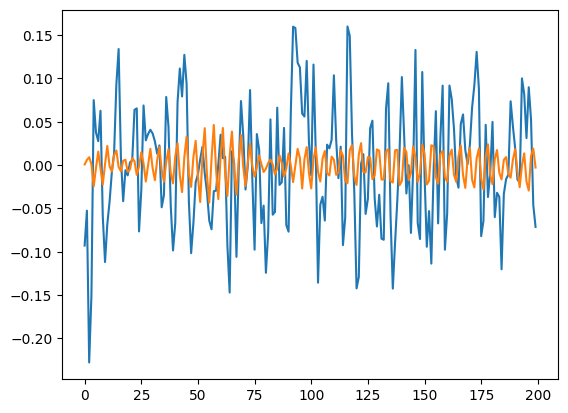

In [75]:
plt.plot(realbkg[0, 0])
plt.plot(ae(torch.FloatTensor(realbkg[0:1])).detach().numpy().flatten())

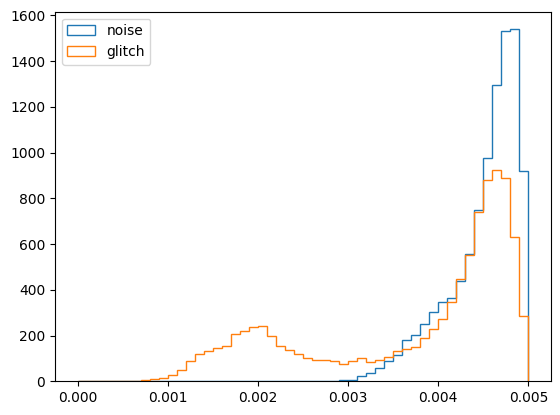

In [76]:
foo = plt.hist(np.var(ae(torch.FloatTensor(realbkg_reserved)).detach().numpy() - realbkg_reserved, axis=-1).flatten(), bins=50, range=(0, 0.005), density=True, histtype="step", label="noise")
foo = plt.hist(np.var(ae(torch.FloatTensor(realglitch_reserved)).detach().numpy() - realglitch_reserved, axis=-1).flatten(), bins=50, range=(0, 0.005), density=True, histtype="step", label="glitch")
plt.legend()

## Test training with GWAK BBH samples

In [7]:
realbbh = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy")[:, 0]
perm = np.random.permutation(len(realbbh))
realbbh = realbbh / np.linalg.norm([realbbh], axis=2).T
realbbh = realbbh[perm]
realbbh = realbbh.reshape(-1,1,200);

In [8]:
np.load("../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz").keys()

KeysView(NpzFile '../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz' with keys: strain, snr)

In [7]:
realbbh = np.load("../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz")['strain'][:, 0]
realbbh_snr = np.load("../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz")['snr']
perm = np.random.permutation(len(realbbh))
realbbh = realbbh / np.linalg.norm([realbbh], axis=2).T
realbbh = realbbh[perm]
realbbh_snr = realbbh_snr[perm]
realbbh = realbbh.reshape(-1,1,200);

In [19]:
realbkg_L = np.load("../Data_cached/real_bkg_2202000_63917s_4000Hz_50ms.npy")[:100000]
# realbbh_snr = np.load("../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz")['snr']
# perm = np.random.permutation(len(realbbh))
realbkg_L = realbkg_L / np.linalg.norm([realbkg_L], axis=2).T
# realbbh = realbbh[perm]
# realbbh_snr = realbbh_snr[perm]
realbkg_L = realbkg_L.reshape(-1,1,200);

In [8]:
realbbh_reserved = realbbh[-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2:]
realbbh = realbbh[:-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2]

In [23]:
n_BBH = len(realbbh)

rTrain = 1-rValidation

n_BBH_train = int(n_BBH * rTrain)
n_BBH_validation = int(n_BBH * rValidation)

In [24]:
X_train = realbbh[:n_BBH_train]
X_validation = realbbh[-n_BBH_validation:]

train_dataset = TensorDataset(torch.FloatTensor(X_train))
valid_dataset = TensorDataset(torch.FloatTensor(X_validation))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

8775


/home/sida/miniconda3/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0001, Training loss=0.082504, Validation loss=0.081003
Time for this epoch: 39.423545837402344
Epoch: 0002, Training loss=0.027945, Validation loss=0.028015
Time for this epoch: 39.11414551734924
Epoch: 0003, Training loss=0.012707, Validation loss=0.012573
Time for this epoch: 39.49436378479004
Epoch: 0004, Training loss=0.007690, Validation loss=0.007483
Time for this epoch: 39.95568251609802
Epoch: 0005, Training loss=0.005940, Validation loss=0.005809
Time for this epoch: 40.01247787475586
Epoch: 0006, Training loss=0.005253, Validation loss=0.005268
Time for this epoch: 39.7333927154541
Epoch: 0007, Training loss=0.005140, Validation loss=0.005097
Time for this epoch: 39.73209738731384
Epoch: 0008, Training loss=0.005060, Validation loss=0.005045
Time for this epoch: 39.592530250549316
Epoch: 0009, Training loss=0.005033, Validation loss=0.005025
Time for this epoch: 40.03423309326172
Epoch: 0010, Training loss=0.005009, Validation loss=0.005015
Time for this epoch: 40.1223

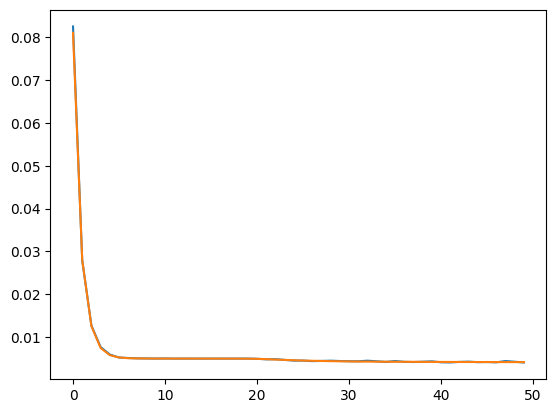

In [25]:
ae = WaveletCNNAE_xc(num_ifos=1, c_depth=5, n_chann=8, l1=20).cpu()
print(sum(p.numel() for p in ae.parameters() if p.requires_grad))

optimizer = optim.Adam(ae.parameters(), lr=0.00002)
loss_func = nn.MSELoss().cpu()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    ae.train()
    for batchidx, x in enumerate(trainDataLoader):
        x = x[0].cpu()
        # print(x.shape)
        # tgt_index = tgt_index.cpu()
        output = ae(x)
        loss = loss_func(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ae.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, x in enumerate(validationDataLoader):
            x = x[0].cpu()
            # tgt_index = tgt_index.cpu()
            output = ae(x)
            lossVal = loss_func(output, x)
            val_loss += lossVal.item()
            # n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f' % (epoch+1, loss_train[epoch], val_loss))
    print('Time for this epoch: ' + str(time.time() - t0))

#     print(time.time() - t0)

plt.plot(loss_train)
plt.plot(loss_validation)

In [ ]:
torch.save(ae, "../results/CNN_bbh.pt")

In [9]:
ae = torch.load('../Model_cached/CNN_bbh.pt')

In [10]:
ae.eval();

In [11]:
realbbh.shape

(1459, 1, 200)

In [16]:
realbbh_snr

array([14.34055418,  9.71541595, 38.15313462, ...,  7.78476064,
       17.67926561, 16.34812571])

In [14]:
np.argwhere(realbbh_snr > 24)

array([[   2],
       [   7],
       [  11],
       [  12],
       [  16],
       [  21],
       [  32],
       [  36],
       [  38],
       [  40],
       [  49],
       [  60],
       [  61],
       [  65],
       [  71],
       [  77],
       [  79],
       [  82],
       [  96],
       [  97],
       [  98],
       [ 102],
       [ 104],
       [ 108],
       [ 113],
       [ 116],
       [ 118],
       [ 129],
       [ 132],
       [ 135],
       [ 138],
       [ 141],
       [ 142],
       [ 143],
       [ 144],
       [ 146],
       [ 153],
       [ 155],
       [ 156],
       [ 163],
       [ 165],
       [ 166],
       [ 168],
       [ 169],
       [ 171],
       [ 173],
       [ 176],
       [ 188],
       [ 189],
       [ 192],
       [ 194],
       [ 196],
       [ 199],
       [ 202],
       [ 205],
       [ 209],
       [ 211],
       [ 213],
       [ 224],
       [ 231],
       [ 233],
       [ 235],
       [ 239],
       [ 244],
       [ 245],
       [ 246],
       [ 2

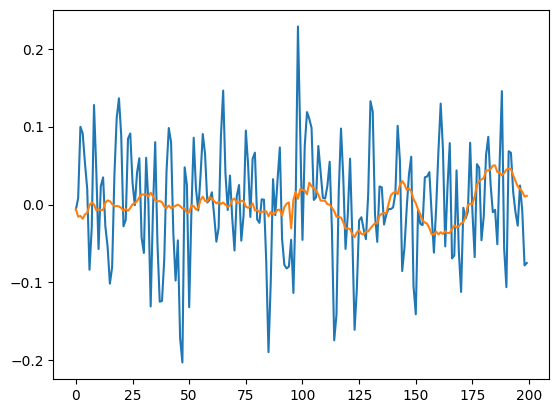

In [16]:
plt.plot(realbbh[0, 0])
plt.plot(ae(torch.FloatTensor(realbbh[0:1])).detach().numpy().flatten())

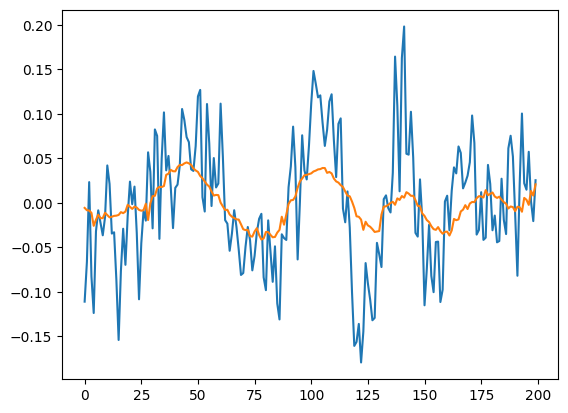

In [17]:
idx = 2

plt.plot(realbbh[idx, 0])
plt.plot(ae(torch.FloatTensor(realbbh[idx:idx+1])).detach().numpy().flatten())

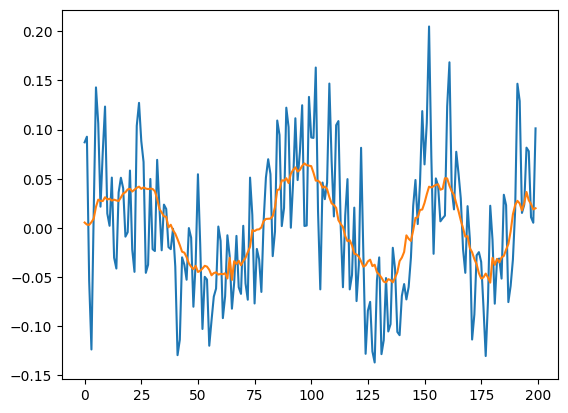

In [26]:
plt.plot(realbbh[0, 0])
plt.plot(ae(torch.FloatTensor(realbbh[0:1])).detach().numpy().flatten())

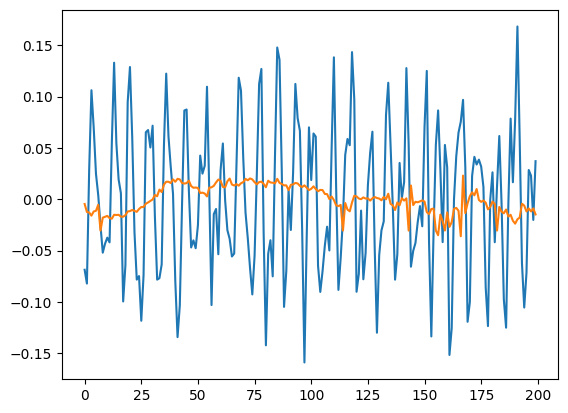

In [29]:
plt.plot(realbkg[0, 0])
plt.plot(ae(torch.FloatTensor(realbkg[0:1])).detach().numpy().flatten())

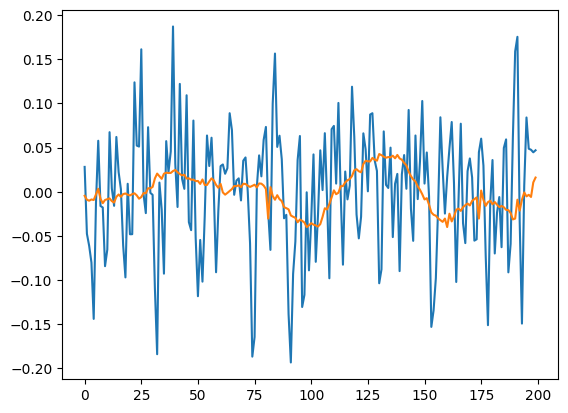

In [21]:
idx = 11

plt.plot(realbkg_L[idx, 0])
plt.plot(ae(torch.FloatTensor(realbkg_L[idx:idx + 1])).detach().numpy().flatten())